# Loading Libraries & Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#I'm from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [ ]:
file_path = '/content/international-airline-passengers.csv'
df = pd.read_csv(file_path)

# Data Exploration

In [ ]:
df = df.iloc[:-1,]

In [ ]:
df.rename(columns={
    'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'Passengers'
}, inplace=True)

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])  # parse strings like '1949-01'
df.set_index('Month', inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB
None


In [ ]:
print(df.isnull().sum())

Month         0
Passengers    0
dtype: int64


In [ ]:
print(df.describe())

                     Month  Passengers
count                  144  144.000000
mean   1954-12-16 05:00:00  280.298611
min    1949-01-01 00:00:00  104.000000
25%    1951-12-24 06:00:00  180.000000
50%    1954-12-16 12:00:00  265.500000
75%    1957-12-08 18:00:00  360.500000
max    1960-12-01 00:00:00  622.000000
std                    NaN  119.966317


In [ ]:
print(df.head())

       Month  Passengers
0 1949-01-01       112.0
1 1949-02-01       118.0
2 1949-03-01       132.0
3 1949-04-01       129.0
4 1949-05-01       121.0


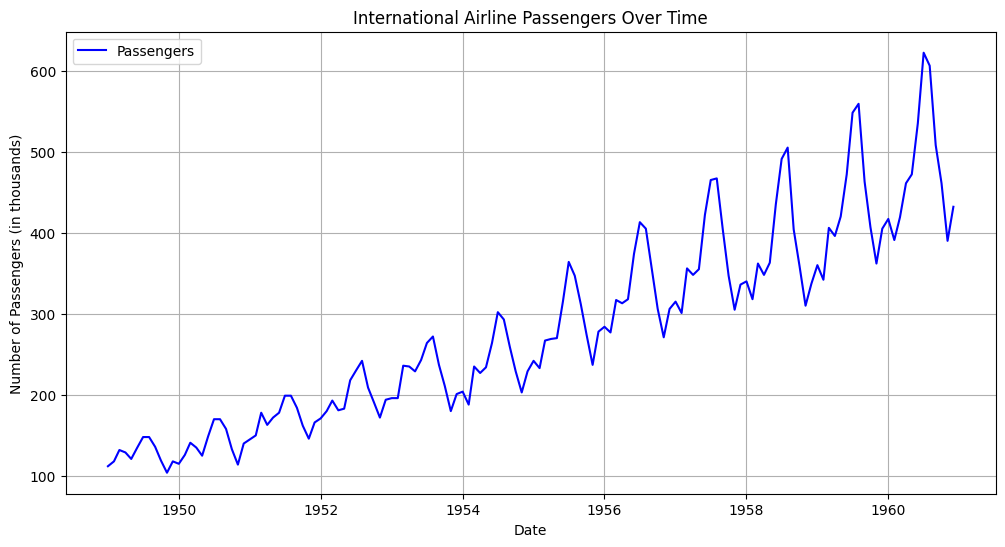

In [ ]:
df_plot = df.copy()

df_plot['Month'] = pd.to_datetime(df_plot['Month'])
df_plot.set_index('Month', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index, df_plot['Passengers'], label='Passengers', color='blue')
plt.title('International Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers (in thousands)')
plt.grid(True)
plt.legend()
plt.show()

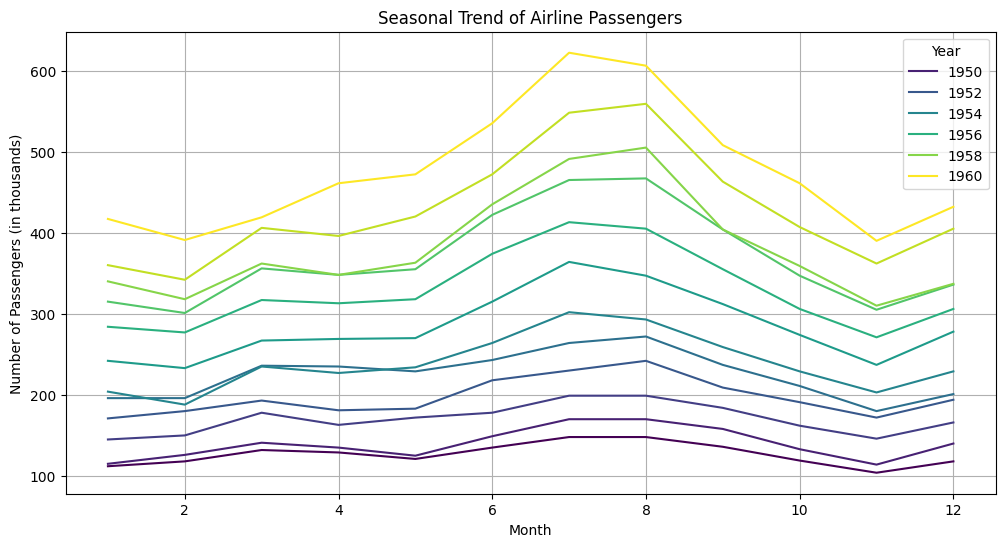

In [ ]:
df_seasonality = df.copy()

df_seasonality['Month'] = pd.to_datetime(df_seasonality['Month'])
df_seasonality.set_index('Month', inplace=True)

df_seasonality['Year'] = df_seasonality.index.year
df_seasonality['Month_Num'] = df_seasonality.index.month

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_seasonality, x='Month_Num', y='Passengers', hue='Year', palette='viridis')
plt.title('Seasonal Trend of Airline Passengers')
plt.xlabel('Month')
plt.ylabel('Number of Passengers (in thousands)')
plt.grid(True)
plt.show()


#3. Initial Model Identification

## Visual Inspection of ACF and PACF

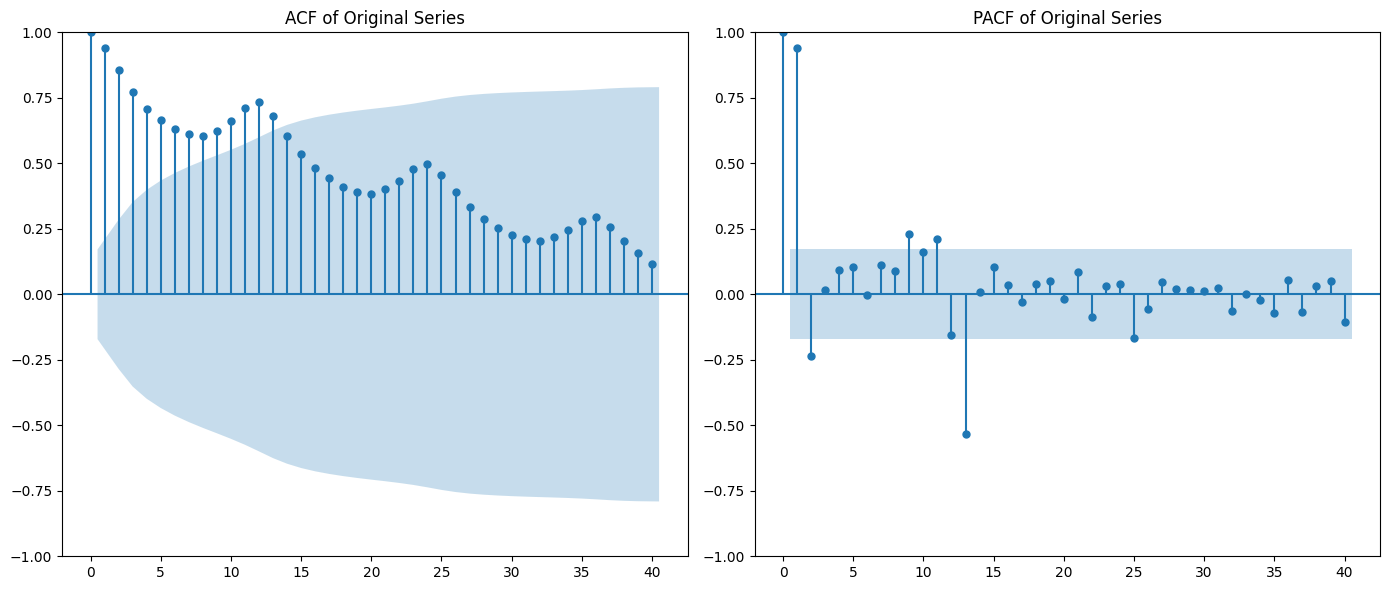

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Passengers'], lags=40, ax=plt.gca())
plt.title('ACF of Original Series')

plt.subplot(1, 2, 2)
plot_pacf(df['Passengers'], lags=40, ax=plt.gca())
plt.title('PACF of Original Series')
plt.tight_layout()
plt.show()

## Stationarity Checking (using ADF test)

In [ ]:
#Stationary check
adf_result = adfuller(df['Passengers'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:', key, value)

ADF Statistic: 0.802475512805303
p-value: 0.9916760225339608
Critical Values: 1% -3.487517288664615
Critical Values: 5% -2.8865777180380032
Critical Values: 10% -2.5801239192052012


So usually, the p-value needs to be lower than 0.05 to say that it is stationary. Now it is obviously not stationary. P-value should be below significance level (0.05) for us to reject. Now it is above. That's why we need to do differencing. But before that let's transform the data to stabilize the variance.

## Data Transformation: Log Transformation

In [ ]:
#Transforming data using log
df['Log_Passengers'] = np.log(df['Passengers'])

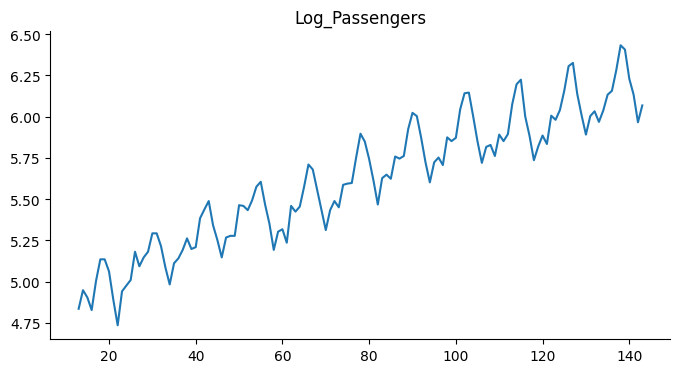

In [ ]:
from matplotlib import pyplot as plt
df['Log_Passengers'].plot(kind='line', figsize=(8, 4), title='Log_Passengers')
plt.gca().spines[['top', 'right']].set_visible(False)

## Differencing

In [ ]:
df['LogDiff1'] = df['Log_Passengers'].diff()
df['LogDiff1_Seasonal'] = df['LogDiff1'].diff(12)
df.dropna(inplace=True)

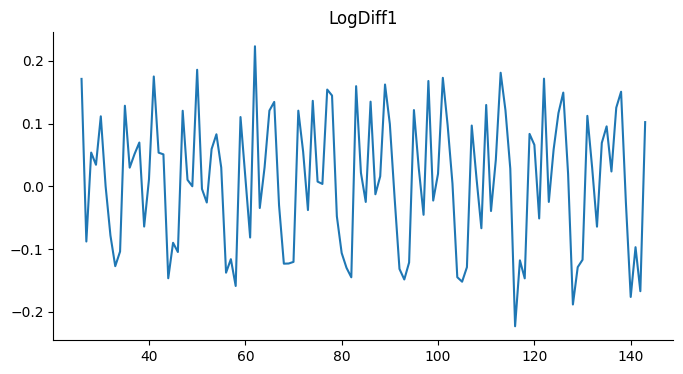

In [ ]:
df['LogDiff1'].plot(kind='line', figsize=(8, 4), title='LogDiff1')
plt.gca().spines[['top', 'right']].set_visible(False)

You can still observe that there is seasonality. So we did seasonal differencing.

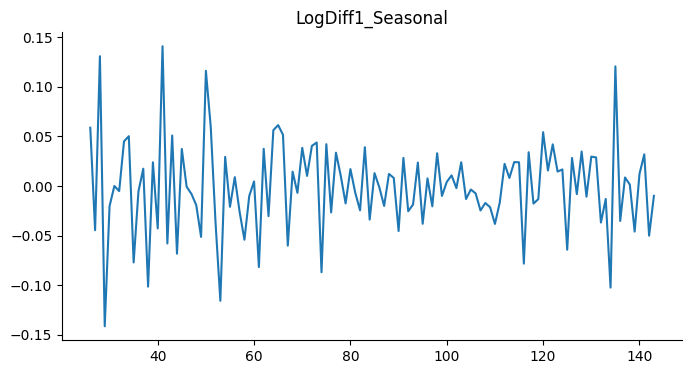

In [ ]:
df['LogDiff1_Seasonal'].plot(kind='line', figsize=(8, 4), title='LogDiff1_Seasonal')
plt.gca().spines[['top', 'right']].set_visible(False)

## Check Stationarity

In [ ]:
result = adfuller(df['LogDiff1_Seasonal'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print('Critical Values:', key, value)

ADF Statistic: -4.039891229855913
p-value: 0.001215446476048088
Critical Values: 1% -3.4936021509366793
Critical Values: 5% -2.8892174239808703
Critical Values: 10% -2.58153320754717


Now as we can see the p value is way less than 0.05 and ADF stat is also lower than critical values. It means it is stationary.

## ACF and PACF after differencing

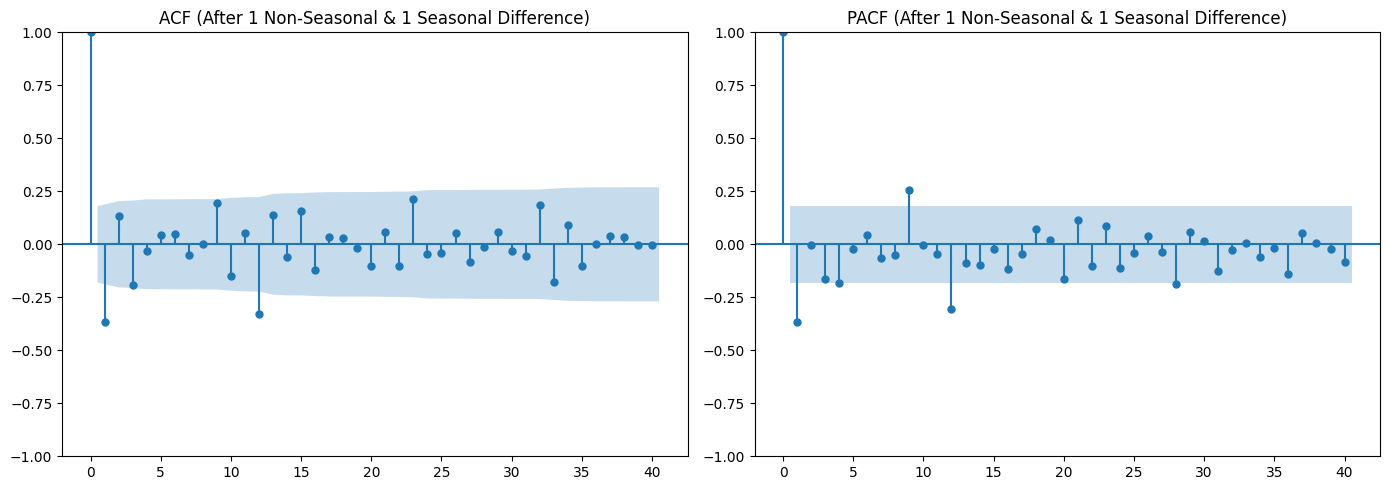

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['LogDiff1_Seasonal'], lags=40, ax=axes[0])
axes[0].set_title("ACF (After 1 Non-Seasonal & 1 Seasonal Difference)")

plot_pacf(df['LogDiff1_Seasonal'], lags=40, ax=axes[1])
axes[1].set_title("PACF (After 1 Non-Seasonal & 1 Seasonal Difference)")

plt.tight_layout()
plt.show()

#  Model Estimation and Diagnostics

## ARIMA (12,1,12)

In [ ]:
#Train
model_arima = ARIMA(df['Log_Passengers'], order=(12,1,12))
result_arima = model_arima.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:         Log_Passengers   No. Observations:                  118
Model:               ARIMA(12, 1, 12)   Log Likelihood                 214.963
Date:                Sat, 15 Feb 2025   AIC                           -379.926
Time:                        12:33:18   BIC                           -310.871
Sample:                             0   HQIC                          -351.890
                                - 118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0527      0.127      0.414      0.679      -0.197       0.302
ar.L2         -0.0885      0.147     -0.602      0.547      -0.377       0.200
ar.L3          0.0156      0.134      0.116      0.9

ARIMA(0,1,1) AIC: -379.925562758008
ARIMA(0,1,1) BIC: -310.8712143880641


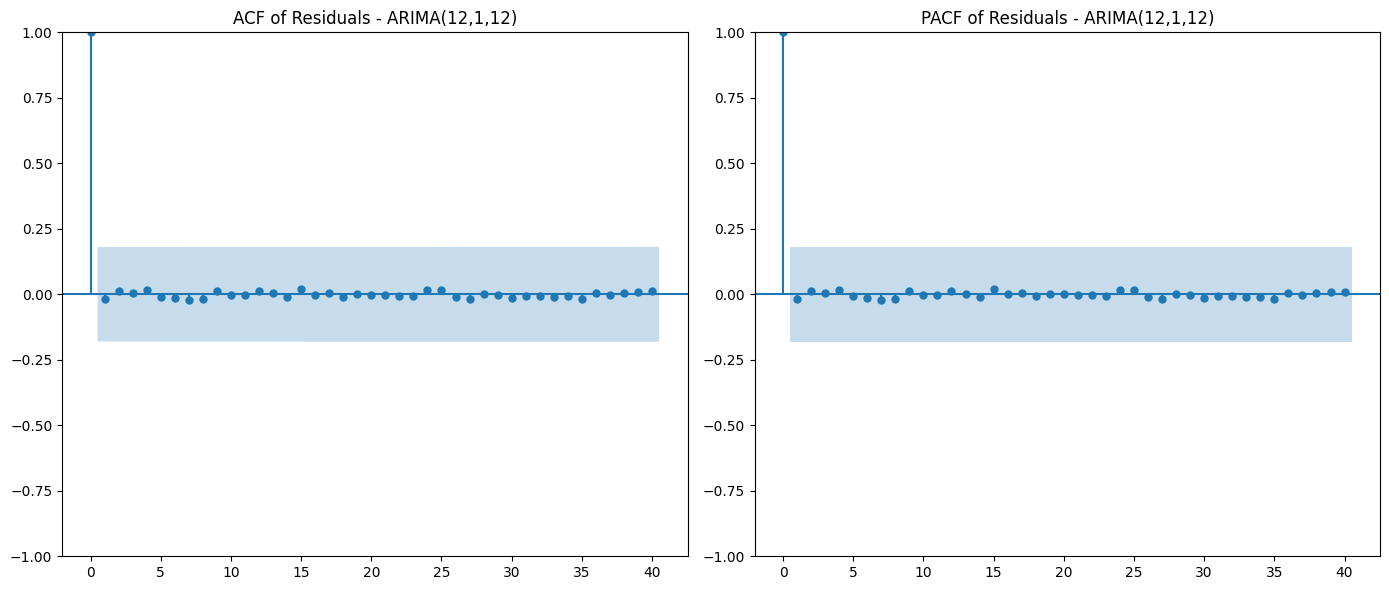


Ljung-Box Test (lags 12, 24) for ARIMA(0,1,1):
     lb_stat  lb_pvalue
12  0.256963        1.0
24  0.401256        1.0


In [ ]:
print(f"ARIMA(0,1,1) AIC: {result_arima.aic}")
print(f"ARIMA(0,1,1) BIC: {result_arima.bic}")

# ACF and PACF
resid_arima = result_arima.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(resid_arima, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals - ARIMA(12,1,12)')
plot_pacf(resid_arima, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF of Residuals - ARIMA(12,1,12)')
plt.tight_layout()
plt.show()

# Ljung-Box test
lb_arima = acorr_ljungbox(resid_arima, lags=[12, 24], return_df=True)
print("\nLjung-Box Test (lags 12, 24) for ARIMA(0,1,1):")
print(lb_arima)

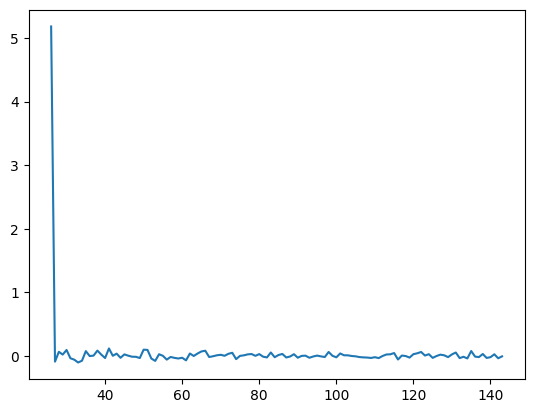

In [ ]:
plt.plot(resid_arima)

We can observe that the residuals closely resembel white noise which indicates our model is a good fit.

## Classic Model - SARIMA (0,1,1)(0,1,1)[12]

In [ ]:
model_011_011 = sm.tsa.statespace.SARIMAX(
    df['Log_Passengers'],
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(model_011_011.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Log_Passengers   No. Observations:                  118
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 182.026
Date:                            Sat, 15 Feb 2025   AIC                           -358.052
Time:                                    12:33:27   BIC                           -350.519
Sample:                                         0   HQIC                          -355.013
                                            - 118                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3240      0.072     -4.479      0.000      -0.466      -0.182
ma.S.L12      -0.5033      0.115   

SARIMA(0,1,1)(0,1,1)[12] AIC: -358.0517878322097
SARIMA(0,1,1)(0,1,1)[12] BIC: -350.51920931265914


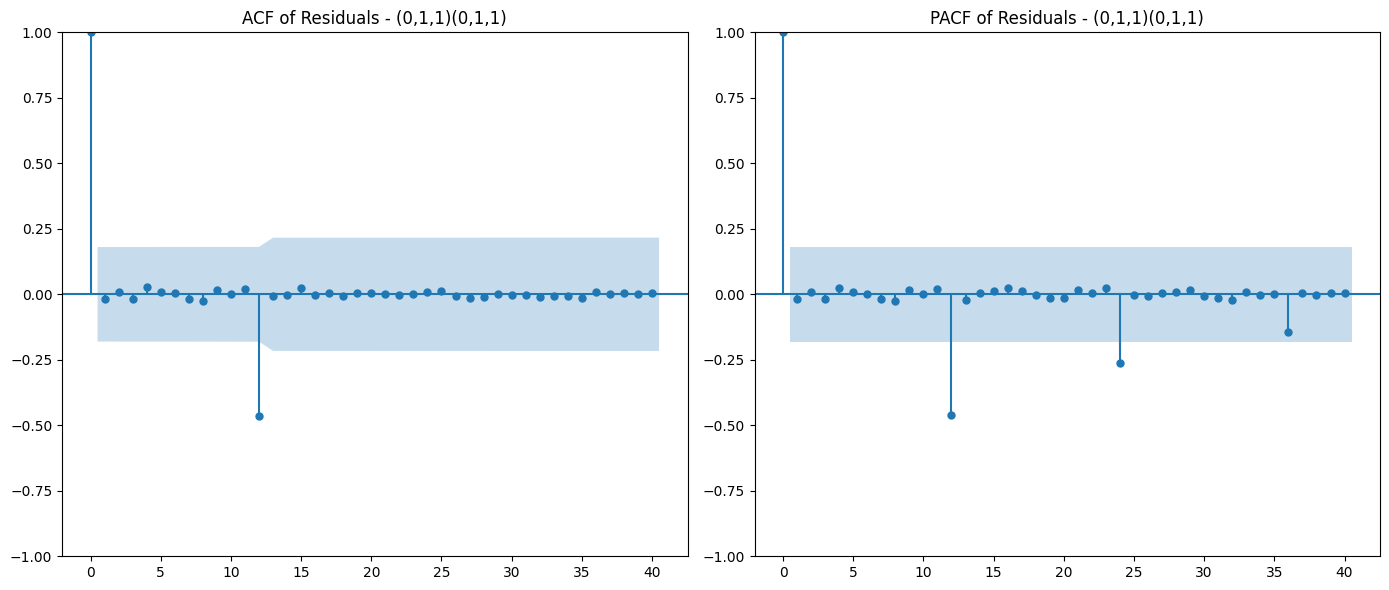


Ljung-Box Test (lags 12, 24) for (0,1,1)(0,1,1):
      lb_stat  lb_pvalue
12  28.992960   0.003949
24  29.106246   0.216158


In [ ]:
print("SARIMA(0,1,1)(0,1,1)[12] AIC:", model_011_011.aic)
print("SARIMA(0,1,1)(0,1,1)[12] BIC:", model_011_011.bic)

# Residual plots
resid_011_011 = model_011_011.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(resid_011_011, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals - (0,1,1)(0,1,1)')
plot_pacf(resid_011_011, lags=40, ax=axes[1])
axes[1].set_title('PACF of Residuals - (0,1,1)(0,1,1)')
plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation in residuals
lb_011_011 = acorr_ljungbox(resid_011_011, lags=[12, 24], return_df=True)
print("\nLjung-Box Test (lags 12, 24) for (0,1,1)(0,1,1):")
print(lb_011_011)

It is strange that the SARIMA's ACF and PACF have a significant autocorrelation in Lag 12, so let's plot the residual to check what happened.

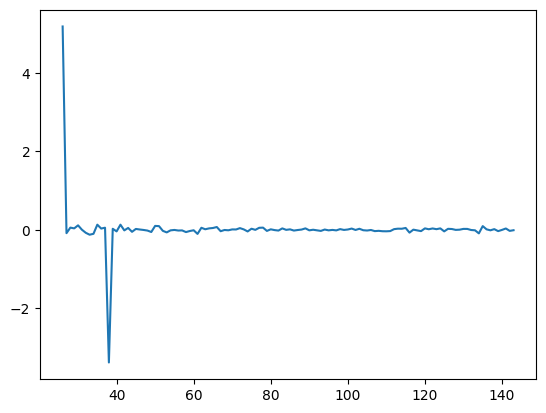

In [ ]:
plt.plot(resid_011_011)

According to the plot, we can identify an outlier at x=24. This outlier contributes to the anomaly where the first point also has a high residual, leading to significant autocorrelation. Therefore, we will drop the first point and recalculate the ACF and PACF.

SARIMA(0,1,1)(0,1,1)[12] AIC: -358.0517878322097
SARIMA(0,1,1)(0,1,1)[12] BIC: -350.51920931265914


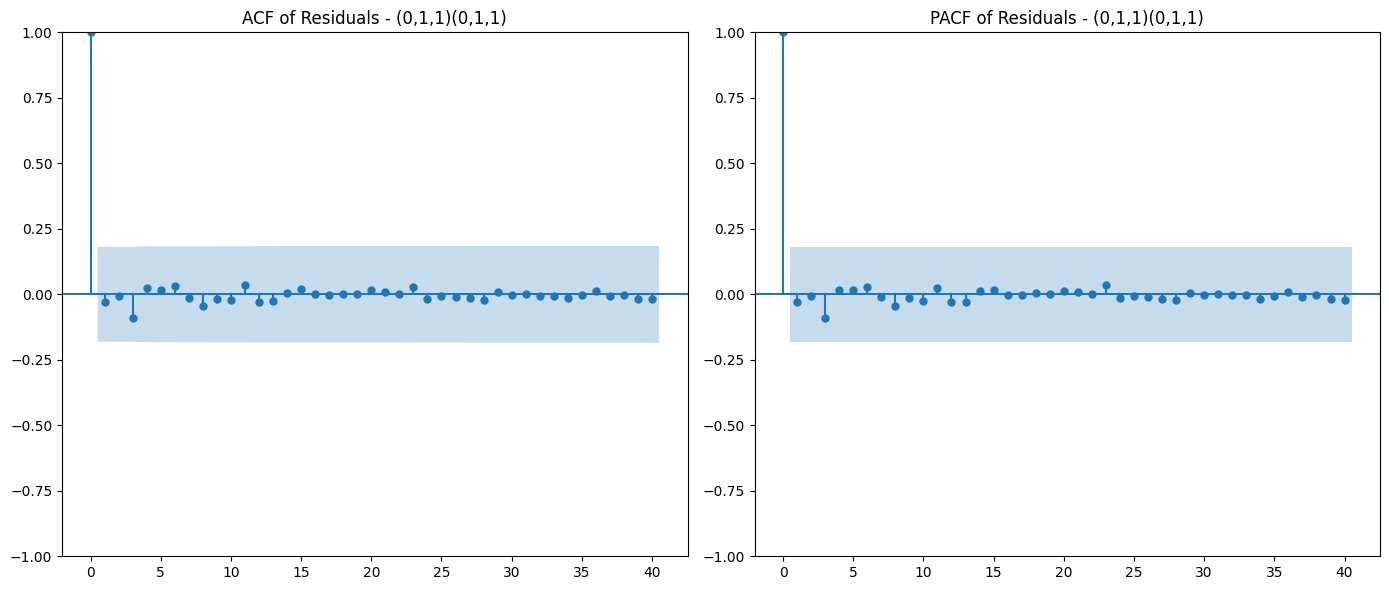


Ljung-Box Test (lags 12, 24) for (0,1,1)(0,1,1):
     lb_stat  lb_pvalue
12  1.946723   0.999483
24  2.346358   1.000000


In [ ]:
print("SARIMA(0,1,1)(0,1,1)[12] AIC:", model_011_011.aic)
print("SARIMA(0,1,1)(0,1,1)[12] BIC:", model_011_011.bic)

# Residual plots
resid_011_011 = model_011_011.resid[1:]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(resid_011_011, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals - (0,1,1)(0,1,1)')
plot_pacf(resid_011_011, lags=40, ax=axes[1])
axes[1].set_title('PACF of Residuals - (0,1,1)(0,1,1)')
plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation in residuals
lb_011_011 = acorr_ljungbox(resid_011_011, lags=[12, 24], return_df=True)
print("\nLjung-Box Test (lags 12, 24) for (0,1,1)(0,1,1):")
print(lb_011_011)

No significant autocorrelation!

## SARIMA(1,1,1)(1,1,1)[12]

In [ ]:
model_111_111 = sm.tsa.statespace.SARIMAX(
    df['Log_Passengers'],
    order=(1, 1, 1),            # (p, d, q)
    seasonal_order=(1, 1, 1, 12), # (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(model_111_111.summary())


                                     SARIMAX Results                                      
Dep. Variable:                     Log_Passengers   No. Observations:                  118
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 181.575
Date:                            Sat, 15 Feb 2025   AIC                           -353.151
Time:                                    12:33:52   BIC                           -340.596
Sample:                                         0   HQIC                          -348.086
                                            - 118                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3235      0.484     -0.668      0.504      -1.273       0.626
ma.L1          0.0251      0.465   

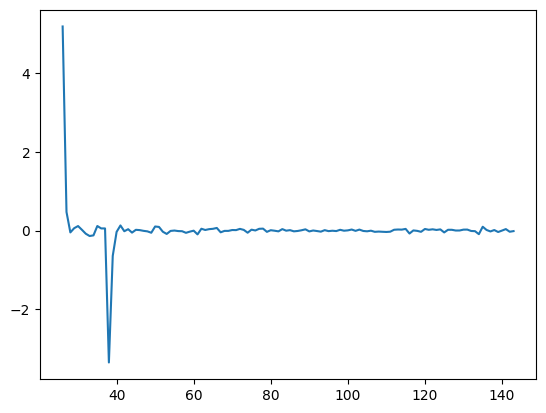

In [ ]:
plt.plot(model_111_111.resid)

SARIMA(1,1,1)(1,1,1)[12] AIC: -353.1505393945592
SARIMA(1,1,1)(1,1,1)[12] BIC: -340.59624186197493


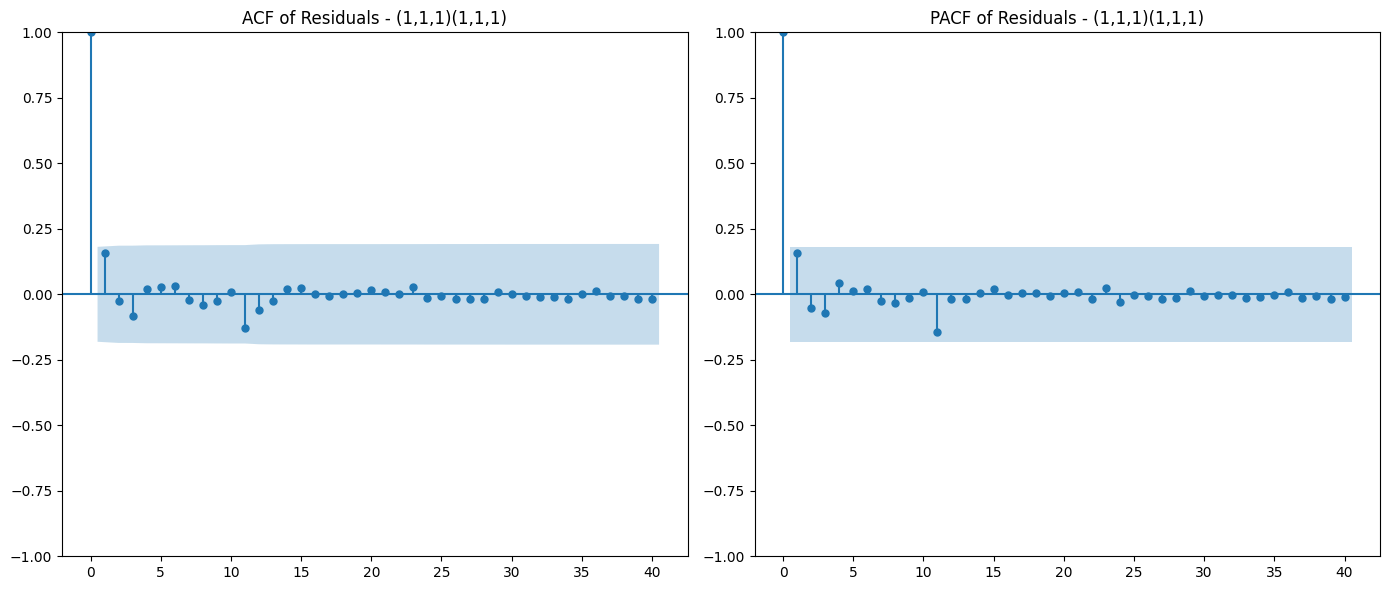


Ljung-Box Test (lags 12, 24) for (1,1,1)(1,1,1):
     lb_stat  lb_pvalue
12  7.197085   0.844319
24  7.624028   0.999392


In [ ]:
print("SARIMA(1,1,1)(1,1,1)[12] AIC:", model_111_111.aic)
print("SARIMA(1,1,1)(1,1,1)[12] BIC:", model_111_111.bic)

# Residual plots
resid_111_111 = model_111_111.resid[1:]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(resid_111_111, lags=40, ax=axes[0])
axes[0].set_title('ACF of Residuals - (1,1,1)(1,1,1)')
plot_pacf(resid_111_111, lags=40, ax=axes[1])
axes[1].set_title('PACF of Residuals - (1,1,1)(1,1,1)')
plt.tight_layout()
plt.show()

# Ljung-Box test
lb_111_111 = acorr_ljungbox(resid_111_111, lags=[12, 24], return_df=True)
print("\nLjung-Box Test (lags 12, 24) for (1,1,1)(1,1,1):")
print(lb_111_111)

# Forecasting

## Splitting the dataset

We split the data set into training and validation (Data for the whole year 1960) to evaluate the performance of our models.

In [ ]:
df.reset_index(inplace=True)

In [ ]:
# 1) Convert 'Month' to datetime
df['Month'] = pd.to_datetime(df['Month'])

# 2) Make it the index
df.set_index('Month', inplace=True)

# 3) Assign a monthly frequency (if it's truly monthly data)
df.index.freq = 'MS'  # 'MS' = Month Start, 'M' = Month End, whichever matches your data

In [ ]:
df.head()

,index,Passengers,Log_Passengers,LogDiff1,LogDiff1_Seasonal
Month,,,,,
1951-03-01,26,178.0,5.181784,0.171148,0.058670
1951-04-01,27,163.0,5.093750,-0.088033,-0.044548
1951-05-01,28,172.0,5.147494,0.053744,0.130705
1951-06-01,29,178.0,5.181784,0.034289,-0.141343
1951-07-01,30,199.0,5.293305,0.111521,-0.020331


In [ ]:
df.columns

Index(['index', 'Passengers', 'Log_Passengers', 'LogDiff1',
       'LogDiff1_Seasonal'],
      dtype='object')

In [ ]:
df_ = df.copy()
df_train = df_.iloc[:-12]
df_train

,index,Passengers,Log_Passengers,LogDiff1,LogDiff1_Seasonal
Month,,,,,
1951-03-01,26,178.0,5.181784,0.171148,0.058670
1951-04-01,27,163.0,5.093750,-0.088033,-0.044548
1951-05-01,28,172.0,5.147494,0.053744,0.130705
1951-06-01,29,178.0,5.181784,0.034289,-0.141343
1951-07-01,30,199.0,5.293305,0.111521,-0.020331
...,...,...,...,...,...
1959-08-01,127,559.0,6.326149,0.019874,-0.008240
1959-09-01,128,463.0,6.137727,-0.188422,0.034721
1959-10-01,129,407.0,6.008813,-0.128914,-0.010821


In [ ]:
df_val = df_.iloc[-12:]
df_val

,index,Passengers,Log_Passengers,LogDiff1,LogDiff1_Seasonal
Month,,,,,
1960-01-01,132,417.0,6.033086,0.029199,-0.036822
1960-02-01,133,391.0,5.968708,-0.064379,-0.013085
1960-03-01,134,419.0,6.037871,0.069163,-0.102379
1960-04-01,135,461.0,6.133398,0.095527,0.120466
1960-05-01,136,472.0,6.156979,0.023581,-0.035260
1960-06-01,137,535.0,6.282267,0.125288,0.008563
1960-07-01,138,622.0,6.432940,0.150673,0.001377
1960-08-01,139,606.0,6.406880,-0.026060,-0.045934
1960-09-01,140,508.0,6.230481,-0.176399,0.012024


## ARIMA(12,1,12)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Train Arima
model_arima = ARIMA(df_train['Log_Passengers'], order=(12,1,12))
result_arima = model_arima.fit()

print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:         Log_Passengers   No. Observations:                  106
Model:               ARIMA(12, 1, 12)   Log Likelihood                 190.150
Date:                Sat, 15 Feb 2025   AIC                           -330.300
Time:                        12:34:15   BIC                           -263.951
Sample:                    03-01-1951   HQIC                          -303.414
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0355      0.140      0.253      0.800      -0.240       0.311
ar.L2         -0.0734      0.139     -0.527      0.598      -0.346       0.199
ar.L3          0.0327      0.134      0.245      0.8

In [ ]:
forecast_steps = 12
forecast_result = result_arima.get_forecast(steps=forecast_steps)

In [ ]:
# 1) Forecast in log scale
predicted_log = forecast_result.predicted_mean

# 2) Convert back to original scale
predicted_passengers = np.exp(predicted_log)

# 3) Confidence intervals
conf_int = forecast_result.conf_int()

lower_log = conf_int['lower Log_Passengers']
upper_log = conf_int['upper Log_Passengers']

lower = np.exp(lower_log)
upper = np.exp(upper_log)

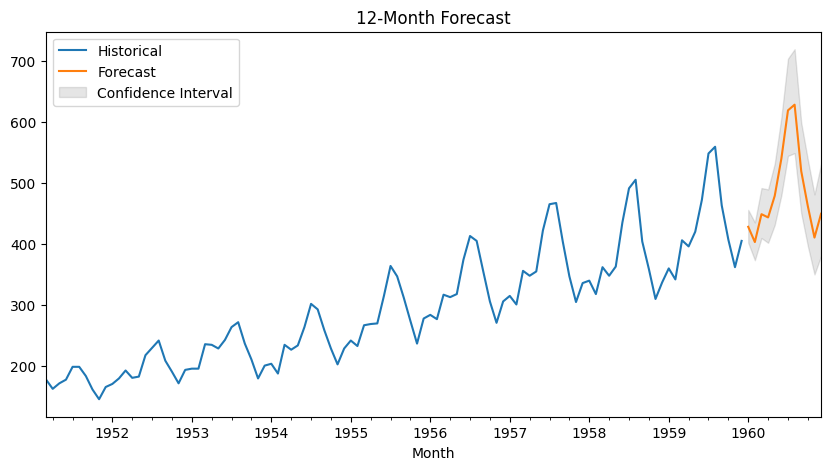

In [ ]:
plt.figure(figsize=(10, 5))

# Plot historical data (original scale)
df_train['Passengers'].plot(label='Historical', legend=True)

# Plot the forecast
predicted_passengers.plot(label='Forecast', legend=True)

# Shade the confidence interval
plt.fill_between(
    predicted_passengers.index,
    lower,
    upper,
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)

plt.title('12-Month Forecast')
plt.legend()
plt.show()

### Evaluation

RMSE: 15.44
MAE: 13.05
MAPE: 2.89%


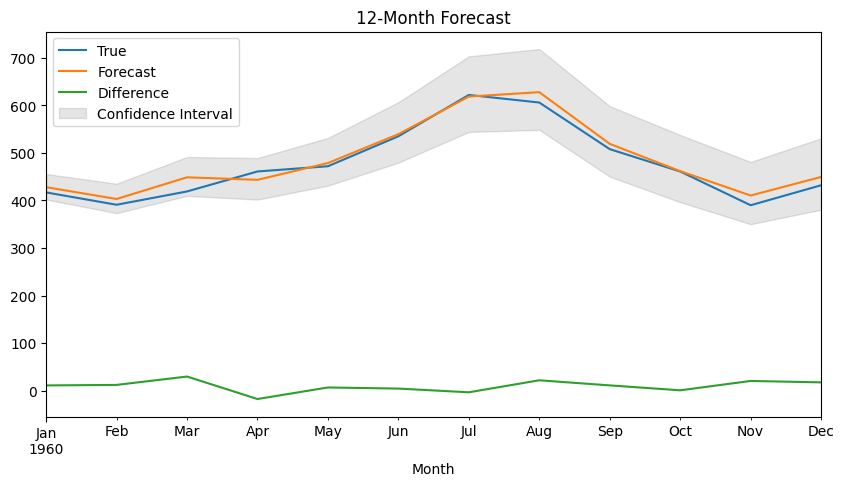

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error(df_val['Passengers'], predicted_passengers))

# MAE
mae = mean_absolute_error(df_val['Passengers'], predicted_passengers)

# MAPE
mape = mean_absolute_percentage_error(df_val['Passengers'], predicted_passengers) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

plt.figure(figsize=(10, 5))

# Plot historical data (original scale)
df_val['Passengers'].plot(label='True', legend=True)

# Plot the forecast
predicted_passengers.plot(label='Forecast', legend=True)

difference = predicted_passengers - df_val['Passengers']
difference.plot(label = 'Difference', legend=True)


# Shade the confidence interval
plt.fill_between(
    predicted_passengers.index,
    lower,
    upper,
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)

plt.title('12-Month Forecast')
plt.legend()
plt.show()

## Classic Model - SARIMA (0,1,1)(0,1,1)[12]

In [ ]:
model = SARIMAX(
    df_train['Log_Passengers'],
    order=(0,1,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Log_Passengers   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 162.727
Date:                            Sat, 15 Feb 2025   AIC                           -319.453
Time:                                    12:34:25   BIC                           -312.345
Sample:                                03-01-1951   HQIC                          -316.605
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2189      0.090     -2.445      0.014      -0.394      -0.043
ma.S.L12      -0.4891      0.102   

In [ ]:
forecast_steps = 12
forecast_result = model.get_forecast(steps=forecast_steps)

# 1) Forecast in log scale
predicted_log = forecast_result.predicted_mean

# 2) Convert back to original scale
predicted_passengers = np.exp(predicted_log)

# 3) Confidence intervals
conf_int = forecast_result.conf_int()

# The columns here typically match the variable name used in the model
# e.g., "lower Log_Passengers" / "upper Log_Passengers"
lower_log = conf_int['lower Log_Passengers']
upper_log = conf_int['upper Log_Passengers']

lower = np.exp(lower_log)
upper = np.exp(upper_log)

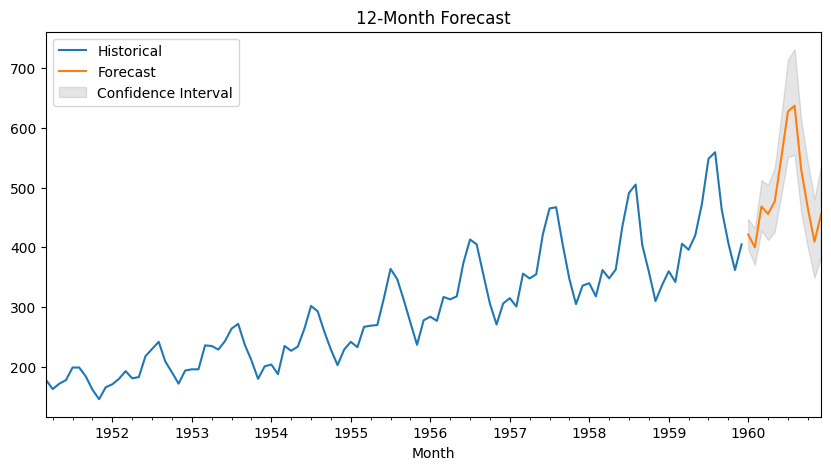

In [ ]:
plt.figure(figsize=(10, 5))

# Plot historical data (original scale)
df_train['Passengers'].plot(label='Historical', legend=True)

# Plot the forecast
predicted_passengers.plot(label='Forecast', legend=True)

# Shade the confidence interval
plt.fill_between(
    predicted_passengers.index,
    lower,
    upper,
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)

plt.title('12-Month Forecast')
plt.legend()
plt.show()

### Evaluation

RMSE: 20.77
MAE: 15.99
MAPE: 3.45%


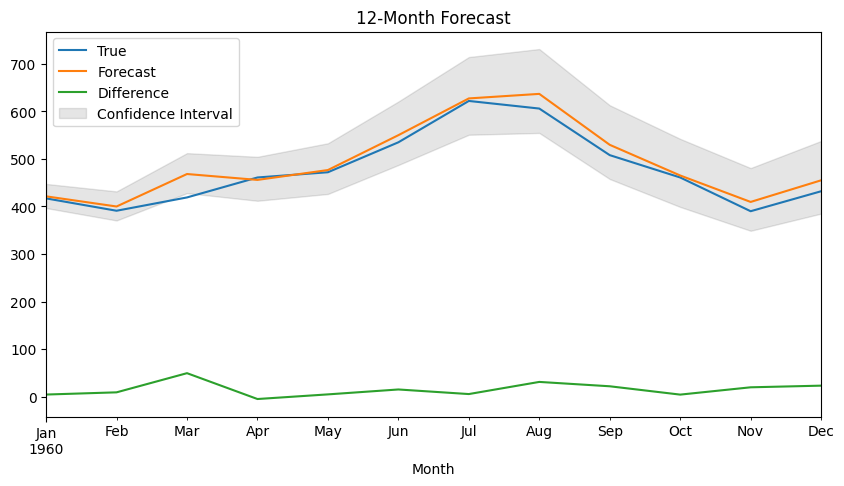

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error(df_val['Passengers'], predicted_passengers))

# MAE
mae = mean_absolute_error(df_val['Passengers'], predicted_passengers)

# MAPE
mape = mean_absolute_percentage_error(df_val['Passengers'], predicted_passengers) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

plt.figure(figsize=(10, 5))

# Plot historical data (original scale)
df_val['Passengers'].plot(label='True', legend=True)

# Plot the forecast
predicted_passengers.plot(label='Forecast', legend=True)

difference = predicted_passengers - df_val['Passengers']
difference.plot(label = 'Difference', legend=True)


# Shade the confidence interval
plt.fill_between(
    predicted_passengers.index,
    lower,
    upper,
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)

plt.title('12-Month Forecast')
plt.legend()
plt.show()

## SARIMA (1,1,1)(1,1,1)[12]

In [ ]:
model = sm.tsa.statespace.SARIMAX(
    df_train['Log_Passengers'],  # your logged passenger series
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Log_Passengers   No. Observations:                  106
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 161.543
Date:                            Sat, 15 Feb 2025   AIC                           -313.086
Time:                                    12:34:34   BIC                           -301.239
Sample:                                03-01-1951   HQIC                          -308.340
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3119      0.618     -0.504      0.614      -1.524       0.900
ma.L1          0.0493      0.588   

In [ ]:
forecast_steps = 12
forecast_result = model.get_forecast(steps=forecast_steps)

In [ ]:
# 1) Forecast in log scale
predicted_log = forecast_result.predicted_mean

# 2) Convert back to original scale
import numpy as np
predicted_passengers = np.exp(predicted_log)

# 3) Confidence intervals
conf_int = forecast_result.conf_int()

# The columns here typically match the variable name used in the model
# e.g., "lower Log_Passengers" / "upper Log_Passengers"
lower_log = conf_int['lower Log_Passengers']
upper_log = conf_int['upper Log_Passengers']

lower = np.exp(lower_log)
upper = np.exp(upper_log)

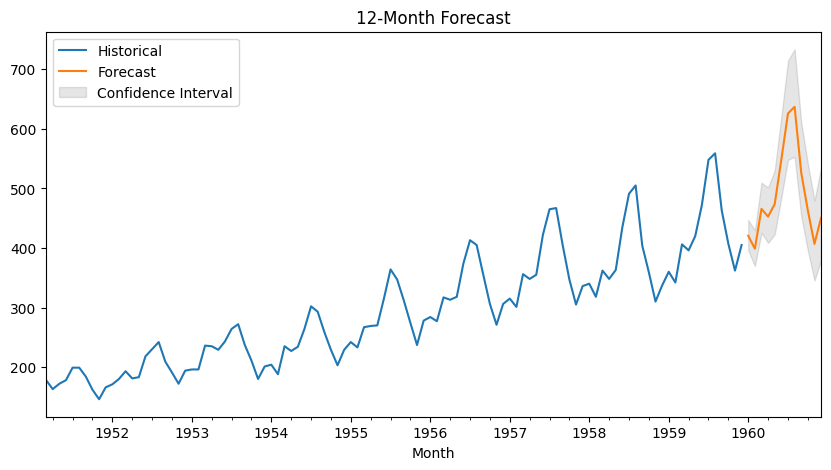

In [ ]:
plt.figure(figsize=(10, 5))

# Plot historical data (original scale)
df_train['Passengers'].plot(label='Historical', legend=True)

# Plot the forecast
predicted_passengers.plot(label='Forecast', legend=True)

# Shade the confidence interval
plt.fill_between(
    predicted_passengers.index,
    lower,
    upper,
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)

plt.title('12-Month Forecast')
plt.legend()
plt.show()

### Evaluation

RMSE: 19.30
MAE: 14.39
MAPE: 3.10%


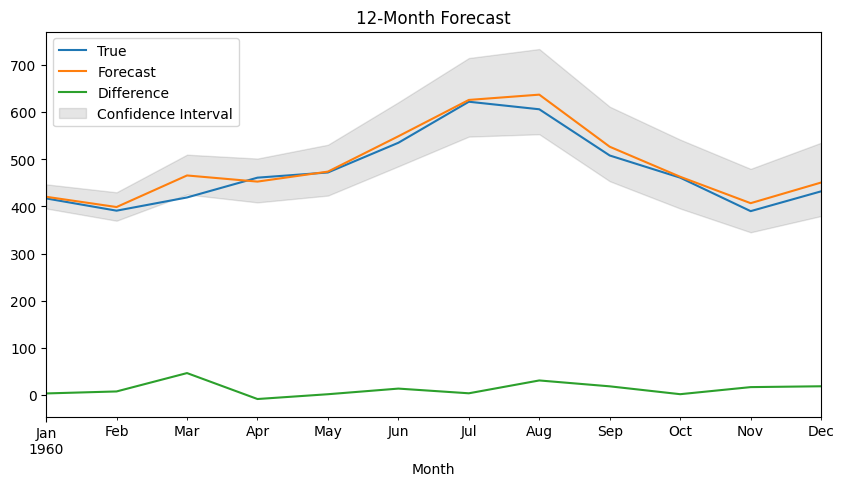

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error(df_val['Passengers'], predicted_passengers))

# MAE
mae = mean_absolute_error(df_val['Passengers'], predicted_passengers)

# MAPE
mape = mean_absolute_percentage_error(df_val['Passengers'], predicted_passengers) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

plt.figure(figsize=(10, 5))

# Plot historical data (original scale)
df_val['Passengers'].plot(label='True', legend=True)

# Plot the forecast
predicted_passengers.plot(label='Forecast', legend=True)

difference = predicted_passengers - df_val['Passengers']
difference.plot(label = 'Difference', legend=True)


# Shade the confidence interval
plt.fill_between(
    predicted_passengers.index,
    lower,
    upper,
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)

plt.title('12-Month Forecast')
plt.legend()
plt.show()